In [52]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import StratifiedShuffleSplit

In [54]:
# Constants
image_size = 128
batch_size = 32
k_folds = 5
epochs = 10
raw_dir = 'PlantVillage_Dataset/raw/color'
base_output = 'split_dataset'
test_ratio = 0.15
data_dir = 'split_dataset/train'

# Step 1: Split raw dataset into train/test folders (only "Tomato*" folders)
for split in ['train', 'test']:
    os.makedirs(os.path.join(base_output, split), exist_ok=True)

for class_name in os.listdir(raw_dir):
    if not class_name.startswith('Tomato'):
        continue  # Skip non-Tomato classes
    class_path = os.path.join(raw_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    train_imgs, test_imgs = train_test_split(images, test_size=test_ratio, random_state=42)

    for split, split_imgs in zip(['train', 'test'], [train_imgs, test_imgs]):
        split_class_dir = os.path.join(base_output, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copyfile(src, dst)

# Step 2: Prepare DataFrame for training images
filepaths, labels = [], []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepaths.append(os.path.join(class_path, fname))
            labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Step 3: Encode labels
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)

# Step 4: Set up cross-validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
datagen = ImageDataGenerator(rescale=1./255)

In [56]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=42)

for fold, (train_idx, val_idx) in enumerate(sss.split(df['filepath'], df['encoded_label'])):
    print(f"\n--- Fold {fold+1} ---")
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_gen = datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_gen = datagen.flow_from_dataframe(
        val_df,
        x_col='filepath',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, validation_data=val_gen, epochs=epochs)

# Step 6: Prepare test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


--- Fold 1 ---
Found 13117 validated image filenames belonging to 10 classes.
Found 2315 validated image filenames belonging to 10 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 97s 234ms/step - accuracy: 0.4619 - loss: 1.5697 - val_accuracy: 0.7749 - val_loss: 0.6488
Epoch 2/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 98s 240ms/step - accuracy: 0.7547 - loss: 0.7132 - val_accuracy: 0.8527 - val_loss: 0.4198
Epoch 3/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 97s 237ms/step - accuracy: 0.8161 - loss: 0.5334 - val_accuracy: 0.8484 - val_loss: 0.4595
Epoch 4/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 94s 230ms/step - accuracy: 0.8422 - loss: 0.4611 - val_accuracy: 0.8717 - val_loss: 0.3563
Epoch 5/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 102s 248ms/step - accuracy: 0.8569 - loss: 0.4076 - val_accuracy: 0.8894 - val_loss: 0.3219
Epoch 6/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 97s 237ms/step - accuracy: 0.8845 - loss: 0.3396 - val_accuracy: 0.8976 - val_loss: 0.2965
Epoch 7/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 97s 238ms/step - accuracy: 0.8841 - loss: 0.3305 - val_accuracy: 0.9015 - val_loss: 0.2982
Epoch 8/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 90s 221ms/step - accuracy: 0.9076 - loss: 0.2726 -

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 96s 232ms/step - accuracy: 0.4714 - loss: 1.5189 - val_accuracy: 0.8207 - val_loss: 0.5599
Epoch 2/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 89s 216ms/step - accuracy: 0.7823 - loss: 0.6474 - val_accuracy: 0.8324 - val_loss: 0.4658
Epoch 3/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 91s 223ms/step - accuracy: 0.8205 - loss: 0.5144 - val_accuracy: 0.8475 - val_loss: 0.4441
Epoch 4/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 91s 222ms/step - accuracy: 0.8522 - loss: 0.4322 - val_accuracy: 0.8873 - val_loss: 0.3366
Epoch 5/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 133s 324ms/step - accuracy: 0.8804 - loss: 0.3577 - val_accuracy: 0.9058 - val_loss: 0.2671
Epoch 6/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 98s 240ms/step - accuracy: 0.8961 - loss: 0.3043 - val_accuracy: 0.9140 - val_loss: 0.2542
Epoch 7/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 88s 215ms/step - accuracy: 0.9175 - loss: 0.2533 - val_accuracy: 0.8968 - val_loss: 0.3058
Epoch 8/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 87s 211ms/step - accuracy: 0.9176 - loss: 0.2441 - val_accur

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 96s 232ms/step - accuracy: 0.4271 - loss: 1.7123 - val_accuracy: 0.8069 - val_loss: 0.6300
Epoch 2/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 1163s 3s/step - accuracy: 0.7309 - loss: 0.7902 - val_accuracy: 0.8428 - val_loss: 0.4665
Epoch 3/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - accuracy: 0.7837 - loss: 0.6352 - val_accuracy: 0.8695 - val_loss: 0.3758
Epoch 4/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 238s 581ms/step - accuracy: 0.8288 - loss: 0.4992 - val_accuracy: 0.8786 - val_loss: 0.3540
Epoch 5/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 79s 192ms/step - accuracy: 0.8508 - loss: 0.4322 - val_accuracy: 0.8864 - val_loss: 0.3218
Epoch 6/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - accuracy: 0.8760 - loss: 0.3583 - val_accuracy: 0.9179 - val_loss: 0.2541
Epoch 7/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 72s 174ms/step - accuracy: 0.8892 - loss: 0.3171 - val_accuracy: 0.9227 - val_loss: 0.2326
Epoch 8/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 73s 177ms/step - accuracy: 0.8955 - loss: 0.3181 - val_accuracy

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 78s 186ms/step - accuracy: 0.4290 - loss: 1.6511 - val_accuracy: 0.7434 - val_loss: 0.8201
Epoch 2/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 75s 182ms/step - accuracy: 0.6966 - loss: 0.8837 - val_accuracy: 0.8194 - val_loss: 0.5323
Epoch 3/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - accuracy: 0.7573 - loss: 0.7012 - val_accuracy: 0.8626 - val_loss: 0.4148
Epoch 4/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 76s 185ms/step - accuracy: 0.8082 - loss: 0.5626 - val_accuracy: 0.8622 - val_loss: 0.4024
Epoch 5/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 76s 184ms/step - accuracy: 0.8326 - loss: 0.4697 - val_accuracy: 0.8847 - val_loss: 0.3448
Epoch 6/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 76s 185ms/step - accuracy: 0.8494 - loss: 0.4330 - val_accuracy: 0.9045 - val_loss: 0.3210
Epoch 7/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 77s 189ms/step - accuracy: 0.8667 - loss: 0.3834 - val_accuracy: 0.9132 - val_loss: 0.2529
Epoch 8/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 81s 197ms/step - accuracy: 0.8773 - loss: 0.3490 - 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


410/410 ━━━━━━━━━━━━━━━━━━━━ 80s 192ms/step - accuracy: 0.4569 - loss: 1.5792 - val_accuracy: 0.7827 - val_loss: 0.6512
Epoch 2/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - accuracy: 0.7245 - loss: 0.7907 - val_accuracy: 0.8410 - val_loss: 0.4729
Epoch 3/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 74s 181ms/step - accuracy: 0.7817 - loss: 0.6252 - val_accuracy: 0.8639 - val_loss: 0.3888
Epoch 4/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 74s 181ms/step - accuracy: 0.8175 - loss: 0.5099 - val_accuracy: 0.8860 - val_loss: 0.3408
Epoch 5/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 74s 181ms/step - accuracy: 0.8417 - loss: 0.4635 - val_accuracy: 0.8782 - val_loss: 0.3670
Epoch 6/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - accuracy: 0.8584 - loss: 0.4189 - val_accuracy: 0.8994 - val_loss: 0.3104
Epoch 7/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 76s 184ms/step - accuracy: 0.8676 - loss: 0.3663 - val_accuracy: 0.9050 - val_loss: 0.2791
Epoch 8/9
410/410 ━━━━━━━━━━━━━━━━━━━━ 76s 185ms/step - accuracy: 0.8932 - loss: 0.3021 - val_accura

86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step


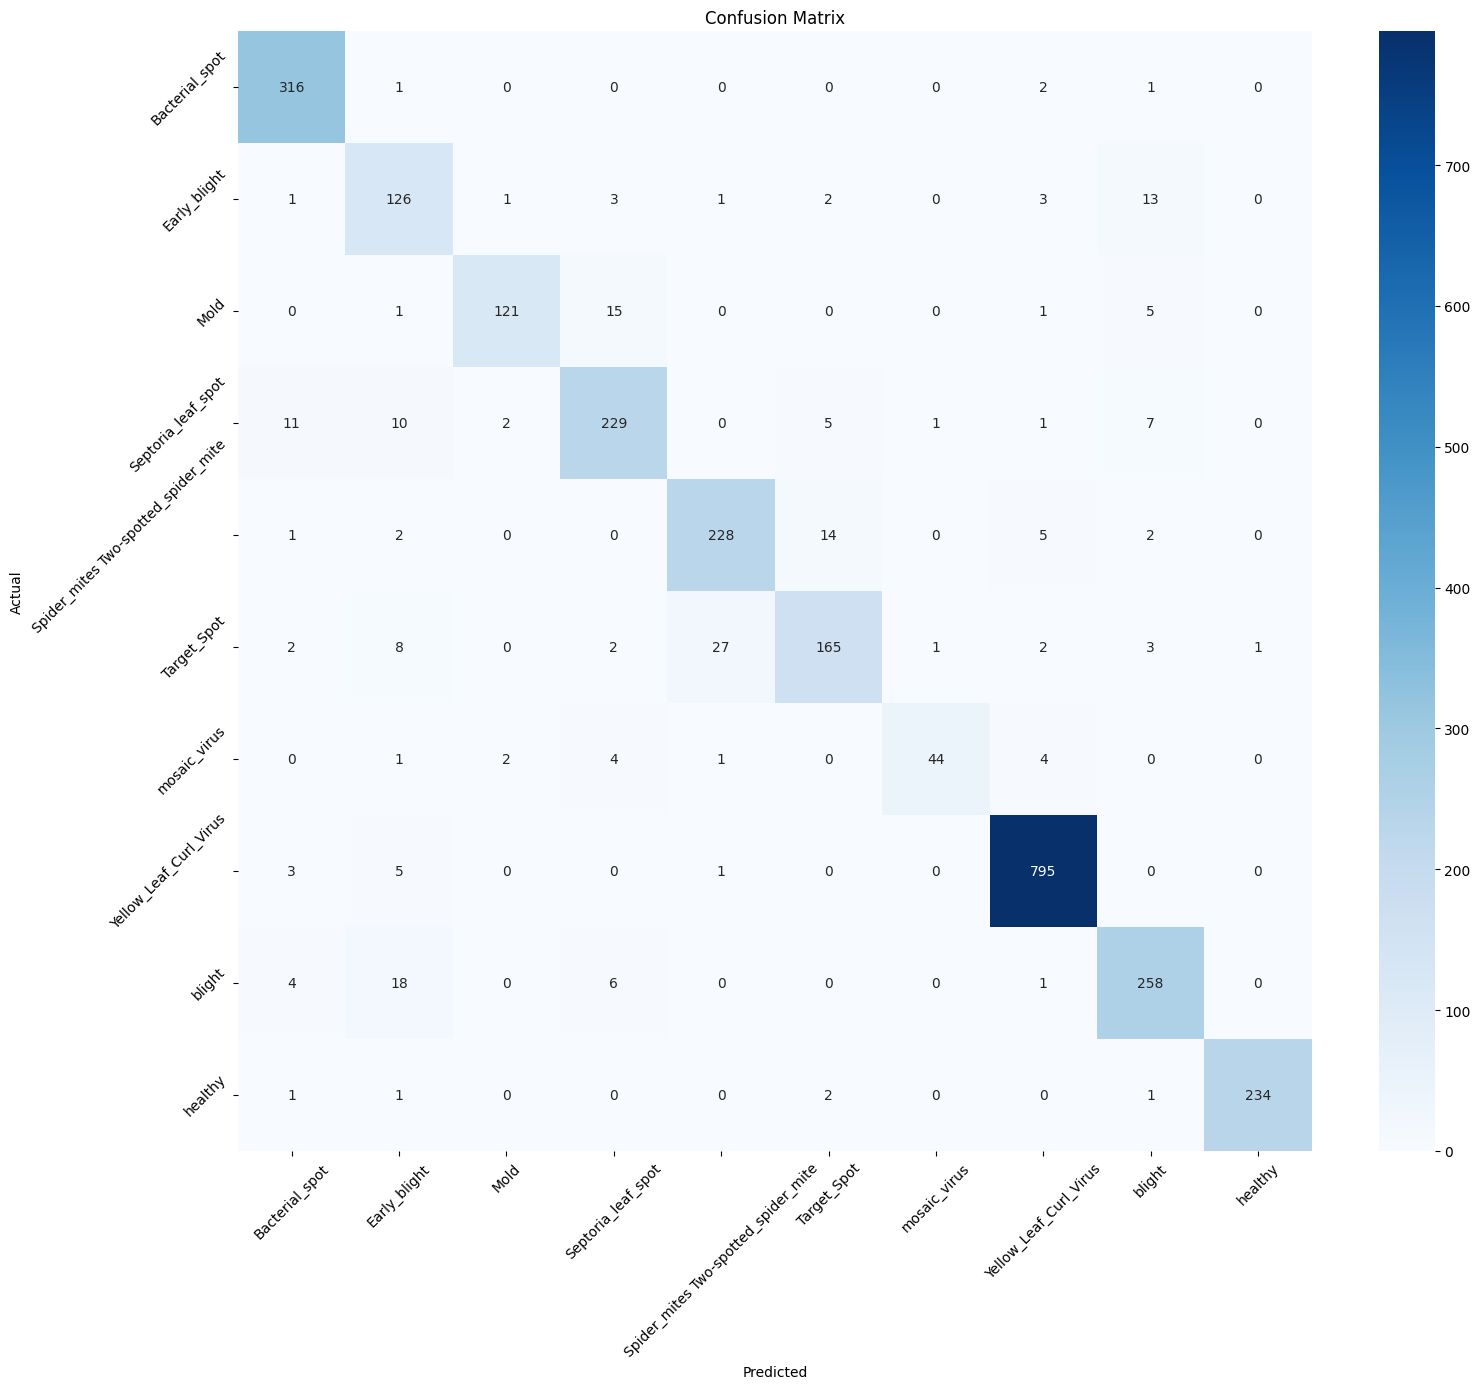

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.93      0.99      0.96       320
                        Early_blight       0.73      0.84      0.78       150
                                Mold       0.96      0.85      0.90       143
                  Septoria_leaf_spot       0.88      0.86      0.87       266
Spider_mites Two-spotted_spider_mite       0.88      0.90      0.89       252
                         Target_Spot       0.88      0.78      0.83       211
                        mosaic_virus       0.96      0.79      0.86        56
              Yellow_Leaf_Curl_Virus       0.98      0.99      0.98       804
                              blight       0.89      0.90      0.89       287
                             healthy       1.00      0.98      0.99       239

                            accuracy                           0.92      2728
                           macro avg       0.91      0.89     

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict labels on test data
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Step 2: True labels
y_true = test_generator.classes

# Step 3: Get class labels (in correct order)
class_labels = [label.replace("Tomato_", "") for label in test_generator.class_indices.keys()]

# Step 4: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 5: Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert to DataFrame for nicer formatting
report_df = pd.DataFrame(report).transpose()

print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
# Machine learning technique 2: support vector machine (SVM)


In [ ]:
# Machine learning technique 3: random forest (RF)
